In this notebook, I will be training SVM classifiers with the pawpularity score and 512 features extracted by a modified CLIP (pre-trained image classifier NN from OpenAI) to predict if the photo is CUTE or NOT CUTE

In [ ]:
!pip install parfit

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Loading & setting up the dataframe (df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
features = pd.read_csv("drive/Shareddrives/Untitled shared drive/petfinder-pawpularity-score/dataset_embedded_final_1.csv")
train_df = pd.read_csv("drive/Shareddrives/Untitled shared drive/petfinder-pawpularity-score/train.csv")

In [ ]:
train_df

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


In [ ]:
features = features.rename(columns={"ID": "Id"})
features

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,Id
0,0.02519,-0.16080,0.248400,0.275000,0.100400,-0.42040,0.401100,0.004078,0.24780,0.2269,...,-0.25760,-0.234700,-0.079160,-0.29320,0.070400,-0.16540,0.537600,-0.04340,-0.008860,0018df346ac9c1d8413cfcc888ca8246
1,0.15770,-0.14750,0.045780,-0.485400,0.004253,-0.29420,0.156100,0.823000,0.32620,0.5767,...,0.06010,0.185700,0.000229,0.09015,-0.626000,-0.31500,-0.076350,-0.02867,0.076350,0042bc5bada6d1cf8951f8f9f0d399fa
2,-0.57960,-0.43650,0.075300,-0.000673,0.035430,-0.06000,-0.002115,0.155900,0.45300,-0.0945,...,0.10640,-0.001005,-0.205000,-0.43970,0.146100,0.10600,0.977500,-0.07745,-0.044700,0049cb81313c94fa007286e9039af910
3,-0.50600,-0.40800,0.295000,0.175300,-0.341000,-0.15330,-0.069100,0.128500,0.17070,-0.2125,...,0.07370,0.033200,-0.041170,-0.16540,-0.210200,0.10560,0.457300,-0.23670,-0.006798,005017716086b8d5e118dd9fe26459b1
4,-0.30270,-0.05150,0.005096,0.309600,0.169700,-0.07336,0.156900,0.367200,0.00805,0.3228,...,-0.35990,-0.637000,0.283400,-0.20780,0.007866,0.04810,0.084900,0.03650,0.287000,00524dbf2637a80cbc80f70d3ff59616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147,-0.04364,-0.04780,0.073300,0.465300,0.008736,-0.54250,0.540500,0.260300,0.47120,0.0896,...,0.14070,-0.563500,-0.088130,-0.49020,-0.118900,-0.03915,0.504400,-0.09820,-0.051800,ff9b3b3468c4b35a3b6450a1ddc88449
4148,-0.05682,-0.38010,0.195400,-0.203900,0.189700,-0.20810,-0.056270,0.459500,0.16900,-0.2068,...,-0.05716,0.335700,0.255400,-0.22060,-0.259000,0.24040,0.557600,-0.41240,0.203200,ffaf7bf7e64b9eecaf02fc2c14d6b654
4149,-0.02016,-0.39060,0.330600,0.306600,0.003513,-0.36570,-0.264200,0.387200,-0.01301,0.1635,...,-0.31030,-0.245500,0.094600,-0.01561,-0.253700,0.47070,0.187700,-0.37280,0.281700,ffb8b466494a3e48bcb874a2fe9b976d
4150,0.21970,0.05580,0.151100,0.076050,-0.041260,-0.71880,0.331800,0.711400,0.18150,0.1998,...,0.01760,-0.184900,0.090150,-0.77730,-0.164600,-0.26460,-0.010445,0.16750,-0.011215,ffcc8532d76436fc79e50eb2e5238e45


In [ ]:
df = features
Pawpularity = train_df.loc[train_df['Id'].isin(features['Id'])][['Id','Pawpularity']]
df = df.merge(Pawpularity, on='Id')
df

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,Id,Pawpularity
0,0.02519,-0.16080,0.248400,0.275000,0.100400,-0.42040,0.401100,0.004078,0.24780,0.2269,...,-0.234700,-0.079160,-0.29320,0.070400,-0.16540,0.537600,-0.04340,-0.008860,0018df346ac9c1d8413cfcc888ca8246,15
1,0.15770,-0.14750,0.045780,-0.485400,0.004253,-0.29420,0.156100,0.823000,0.32620,0.5767,...,0.185700,0.000229,0.09015,-0.626000,-0.31500,-0.076350,-0.02867,0.076350,0042bc5bada6d1cf8951f8f9f0d399fa,53
2,-0.57960,-0.43650,0.075300,-0.000673,0.035430,-0.06000,-0.002115,0.155900,0.45300,-0.0945,...,-0.001005,-0.205000,-0.43970,0.146100,0.10600,0.977500,-0.07745,-0.044700,0049cb81313c94fa007286e9039af910,21
3,-0.50600,-0.40800,0.295000,0.175300,-0.341000,-0.15330,-0.069100,0.128500,0.17070,-0.2125,...,0.033200,-0.041170,-0.16540,-0.210200,0.10560,0.457300,-0.23670,-0.006798,005017716086b8d5e118dd9fe26459b1,28
4,-0.30270,-0.05150,0.005096,0.309600,0.169700,-0.07336,0.156900,0.367200,0.00805,0.3228,...,-0.637000,0.283400,-0.20780,0.007866,0.04810,0.084900,0.03650,0.287000,00524dbf2637a80cbc80f70d3ff59616,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147,-0.04364,-0.04780,0.073300,0.465300,0.008736,-0.54250,0.540500,0.260300,0.47120,0.0896,...,-0.563500,-0.088130,-0.49020,-0.118900,-0.03915,0.504400,-0.09820,-0.051800,ff9b3b3468c4b35a3b6450a1ddc88449,44
4148,-0.05682,-0.38010,0.195400,-0.203900,0.189700,-0.20810,-0.056270,0.459500,0.16900,-0.2068,...,0.335700,0.255400,-0.22060,-0.259000,0.24040,0.557600,-0.41240,0.203200,ffaf7bf7e64b9eecaf02fc2c14d6b654,31
4149,-0.02016,-0.39060,0.330600,0.306600,0.003513,-0.36570,-0.264200,0.387200,-0.01301,0.1635,...,-0.245500,0.094600,-0.01561,-0.253700,0.47070,0.187700,-0.37280,0.281700,ffb8b466494a3e48bcb874a2fe9b976d,31
4150,0.21970,0.05580,0.151100,0.076050,-0.041260,-0.71880,0.331800,0.711400,0.18150,0.1998,...,-0.184900,0.090150,-0.77730,-0.164600,-0.26460,-0.010445,0.16750,-0.011215,ffcc8532d76436fc79e50eb2e5238e45,70


How do we decide if the photo is CUTE or NOT CUTE based on the Pawpularity score?

In [ ]:
sum(df['Pawpularity']>20)/4152

0.8639210019267822

In [ ]:
df['Pawpularity'].describe()

count    4152.000000
mean       37.974711
std        20.497571
min         1.000000
25%        25.000000
50%        33.000000
75%        46.000000
max       100.000000
Name: Pawpularity, dtype: float64

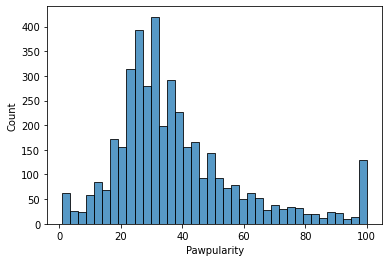

In [ ]:
sns.histplot(data=df, x="Pawpularity")

Considering the mean and the distribution, I've decided to set the bound for 'CUTE' to be pawpularity score bigger or equal to 33

In [ ]:
df['CUTE'] = False
for i in range(0,len(df)):
    if df['Pawpularity'][i] >= 33:
        df['CUTE'][i] = True
    else:
        df['CUTE'][i] = False
        
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,Id,Pawpularity,CUTE
0,0.02519,-0.16080,0.248400,0.275000,0.100400,-0.42040,0.401100,0.004078,0.24780,0.2269,...,-0.079160,-0.29320,0.070400,-0.16540,0.537600,-0.04340,-0.008860,0018df346ac9c1d8413cfcc888ca8246,15,False
1,0.15770,-0.14750,0.045780,-0.485400,0.004253,-0.29420,0.156100,0.823000,0.32620,0.5767,...,0.000229,0.09015,-0.626000,-0.31500,-0.076350,-0.02867,0.076350,0042bc5bada6d1cf8951f8f9f0d399fa,53,True
2,-0.57960,-0.43650,0.075300,-0.000673,0.035430,-0.06000,-0.002115,0.155900,0.45300,-0.0945,...,-0.205000,-0.43970,0.146100,0.10600,0.977500,-0.07745,-0.044700,0049cb81313c94fa007286e9039af910,21,False
3,-0.50600,-0.40800,0.295000,0.175300,-0.341000,-0.15330,-0.069100,0.128500,0.17070,-0.2125,...,-0.041170,-0.16540,-0.210200,0.10560,0.457300,-0.23670,-0.006798,005017716086b8d5e118dd9fe26459b1,28,False
4,-0.30270,-0.05150,0.005096,0.309600,0.169700,-0.07336,0.156900,0.367200,0.00805,0.3228,...,0.283400,-0.20780,0.007866,0.04810,0.084900,0.03650,0.287000,00524dbf2637a80cbc80f70d3ff59616,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147,-0.04364,-0.04780,0.073300,0.465300,0.008736,-0.54250,0.540500,0.260300,0.47120,0.0896,...,-0.088130,-0.49020,-0.118900,-0.03915,0.504400,-0.09820,-0.051800,ff9b3b3468c4b35a3b6450a1ddc88449,44,True
4148,-0.05682,-0.38010,0.195400,-0.203900,0.189700,-0.20810,-0.056270,0.459500,0.16900,-0.2068,...,0.255400,-0.22060,-0.259000,0.24040,0.557600,-0.41240,0.203200,ffaf7bf7e64b9eecaf02fc2c14d6b654,31,False
4149,-0.02016,-0.39060,0.330600,0.306600,0.003513,-0.36570,-0.264200,0.387200,-0.01301,0.1635,...,0.094600,-0.01561,-0.253700,0.47070,0.187700,-0.37280,0.281700,ffb8b466494a3e48bcb874a2fe9b976d,31,False
4150,0.21970,0.05580,0.151100,0.076050,-0.041260,-0.71880,0.331800,0.711400,0.18150,0.1998,...,0.090150,-0.77730,-0.164600,-0.26460,-0.010445,0.16750,-0.011215,ffcc8532d76436fc79e50eb2e5238e45,70,True


Now, Support Vector Regressor using scikitlearn

In [ ]:
# train_features = df.iloc[:, 0:512]
# train_label = df[['Pawpularity']]

# kf = KFold(n_splits = 4)

# X_train, X_test, y_train, y_test = train_test_split(train_features,train_label,test_size = 0.25)

In [ ]:
# param_tuning = {
#         'kernel': ['linear','poly', 'rbf', 'sigmoid'],
#         'C': [1,0.1,0.01] }

# gsearch = GridSearchCV(estimator = svr,
#                        param_grid = param_tuning,                        
#                        cv = 5,
#                        n_jobs = -1,
#                        verbose = 1)
# gsearch.fit(X_train,y_train)
# gsearch.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'C': 0.1, 'kernel': 'linear'}

In [ ]:
# svr = SVR(C=0.1,kernel='linear')

# svr = svr.fit(X_train, y_train)
# pred = svr.predict(X_test);y_true = y_test
# print('RMSE {:.2f}'.format(mean_squared_error(pred,y_true,squared = False)))

17.75 RNSE is quite bad... It seems like making a regressor this way isn't an option. I'm going to try training an efficient net or ResNet based neural network with a dense layer at the end outputtng 1 number later when I get a GPU.

Now, just regular SVM for binary classification (CUTE or NOT CUTE)

In [ ]:
train_features = df.iloc[:, 0:512]
train_label = df[['CUTE']]

kf = KFold(n_splits = 4)

X_train, X_test, y_train, y_test = train_test_split(train_features,train_label,test_size = 0.25)

In [ ]:
svc = SVC()

In [ ]:
param_grid = {'C': [.001, .01, .1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly', 'sigmoid','rbf']}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

grid.fit(X_train,y_train)
grid.best_params_
# I ran this locally and got C=.1, Gamma=1, Kernel: 'linear'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_features,train_label,test_size = 0.25)

svc = SVC(C=0.1,kernel='linear')

svc = svc.fit(X_train, y_train)
pred = svc.predict(X_test);y_true = y_test

print('accuracy %s' % accuracy_score(pred, y_true))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy 0.6685934489402697


I tried rbf, poly, sigmoid, but it seems like linear is the most accurate so far... (I tried running GridSearchCV for each)

Now, I'm going to try SGDClassifier which is SVM trainined with stochastic gradient descent (similar to how NN is trained).

In [ ]:
train_features = df.iloc[:, 0:512]
train_label = df[['CUTE']]

kf = KFold(n_splits = 4)

X_train, X_test, y_train, y_test = train_test_split(train_features,train_label,test_size = 0.25)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    2.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    2.5s finished


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.1s finished


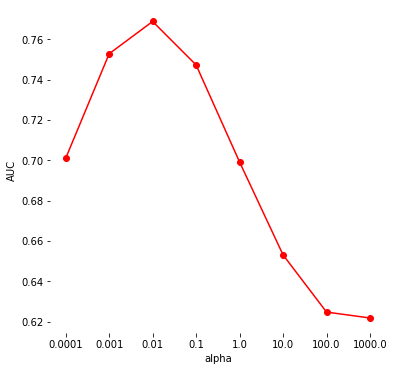

SGDClassifier(alpha=0.01, loss='log', n_jobs=-1) 0.7687930186823992


In [ ]:
grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'max_iter': [1000], # number of epochs
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           X_train, y_train, X_test, y_test, 
           metric = roc_auc_score,
           scoreLabel = "AUC")

print(bestModel, bestScore)

It seems like this model gives the most accurate output so far